# COSE362 Machine Learning Final Report

2017320108 고재영

2017320118 임규정

2017320121 이준구

Used Dataset: https://www.kaggle.com/datasets/dorianvoydie/2019-database-of-road-traffic-injuries


**Importing Libraries**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import sklearn.preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import preprocessing, tree
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Logistic regression 관련
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

#numerical values work as seeds. None is random
randomness = 40 

**Loading Google Drive**

In [ ]:
# 첨부된 Dataset 파일들을 포함한 폴더의 위치에 따라 수정해주시면 감사하겠습니다.

from google.colab import drive #안쓰면 삭제가능
drive.mount('/content/drive') #안쓰면 삭제가능
data_location = '/content/drive/MyDrive/기계학습/'; #/로 끝나야함


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading Dataframes**

In [ ]:
#load datasets into dataframes
caracteristiques_df = pd.read_csv(data_location+'caracteristiques-2019.csv', encoding_errors = 'ignore')
lieux_df = pd.read_csv(data_location+'lieux-2019.csv')
usagers_df = pd.read_csv(data_location+'usagers-2019.csv')

#selecting data that matches our experiment
caracteristiques_df = caracteristiques_df[['Num_Acc', 'hrmn', 'lum', 'int', 'atm']]
lieux_df = lieux_df[['Num_Acc', 'catr', 'circ', 'surf', 'infra']]
usagers_df = usagers_df[['Num_Acc', 'grav']]

#merge data on same accident number
features_df = pd.merge(caracteristiques_df, lieux_df, on=['Num_Acc']) 

#original data has -1 to be undefined. Hence, we put -1 on NaN as well
features_df.fillna(-1, inplace = True) 

#usagers have repeating accident number but multiple labels hence we want all the unique combinations
features_df = pd.merge (features_df, usagers_df, on="Num_Acc", how="outer").drop_duplicates().reset_index(drop=True) 

#original data has 24 hour between 0 (00:00) to 1 (24:00)
features_df['hrmn'] = features_df['hrmn'].apply(lambda x: x * 24) 

#check if there are any null values
print(features_df.isnull().values.any()) 
print(features_df.shape)

#replace the numbers with their actual labels (given by the dataset readme)
features_df["lum"] = features_df["lum"].map({-1:"not_specified", 1:"full_day",2:"twilight_or_dawn",3:"public_light",4:"night_with_public_light_not_on",5:"night_with_public_light_on"})
features_df["int"] = features_df["int"].map({-1:"not_specified", 1:"excluding_intersection",2:"X_intersection",3:"T_intersection",4:"Y_intersection",5:"intersecton_with_more_than_4_branches", 6:"roundabout", 7:"place", 8:"level_crossing", 9:"other_intersection"})
features_df["atm"] = features_df["atm"].map({-1:"not_specified", 1:"normal",2:"light_rain",3:"heavy_rain",4:"snow_hail",5:"fog_smoke", 6:"strong_wind_storm", 7:"dazzling_weather", 8:"cloudy_weather", 9:"other_atmosphere"})
features_df["catr"] = features_df["catr"].map({-1:"not_specified", 1:"highway",2:"national_road",3:"departmental_road",4:"communal_road",5:"outside_the_public_network", 6:"parking_lot_open_to_public_traffic", 7:"urban_metropolis_roads",9:"other_roads"}) #they skipped 8 for some reason
features_df["circ"] = features_df["circ"].map({-1:"not_specified",1:"oneway",2:"bidirectional",3:"separate_carriage",4:"variable_assignment", 10:"other_traffic"})
features_df["surf"] = features_df["surf"].map({-1:"not_specified",1:"normal",2:"wet",3:"puddles",4:"flooded", 5:"snowy", 6:"mud", 7:"icy", 8:"fat_oil", 9:"other_surface_condition"})
features_df["infra"] = features_df["infra"].map({-1:"not_specified",0:"none",1:"underground_tunnel",2:"bridge_flyover",3:"exchange_or_connection",4:"railroad", 5:"crossroads", 6:"pedestrian_zone", 7:"toll_zone", 8:"site", 9:"other_infrastructure"})
features_df['grav'] = features_df['grav'].map({1:"noharm", 2:"dead", 3:"slight", 4:"very"})

#checking
features_df.head()

False
(104345, 10)


,Num_Acc,hrmn,lum,int,atm,catr,circ,surf,infra,grav
0,201900000001,1.500000,night_with_public_light_not_on,excluding_intersection,normal,highway,separate_carriage,normal,bridge_flyover,very
1,201900000001,1.500000,night_with_public_light_not_on,excluding_intersection,normal,highway,separate_carriage,normal,bridge_flyover,noharm
2,201900000002,2.833333,public_light,excluding_intersection,normal,highway,oneway,normal,none,very
3,201900000003,15.250000,full_day,excluding_intersection,normal,highway,separate_carriage,normal,none,noharm
4,201900000003,15.250000,full_day,excluding_intersection,normal,highway,separate_carriage,normal,none,very


**Separating features and labels**

In [ ]:
 #get label data separate
label_df = features_df[['grav']]

#get rid of Num_Acc since it is no longer needed and does nothing and drop label from features
features_df = features_df.drop(columns = ['grav', 'Num_Acc']) 

**One hot encoding**

In [ ]:
features_df = pd.get_dummies(features_df, drop_first = True)

**Upsampling**

In [ ]:
#we are upsampling everything that is not the majority
oversample = SMOTE(sampling_strategy = "not majority", random_state = randomness)
X,Y = oversample.fit_resample(features_df, label_df)

**Feature Selection**




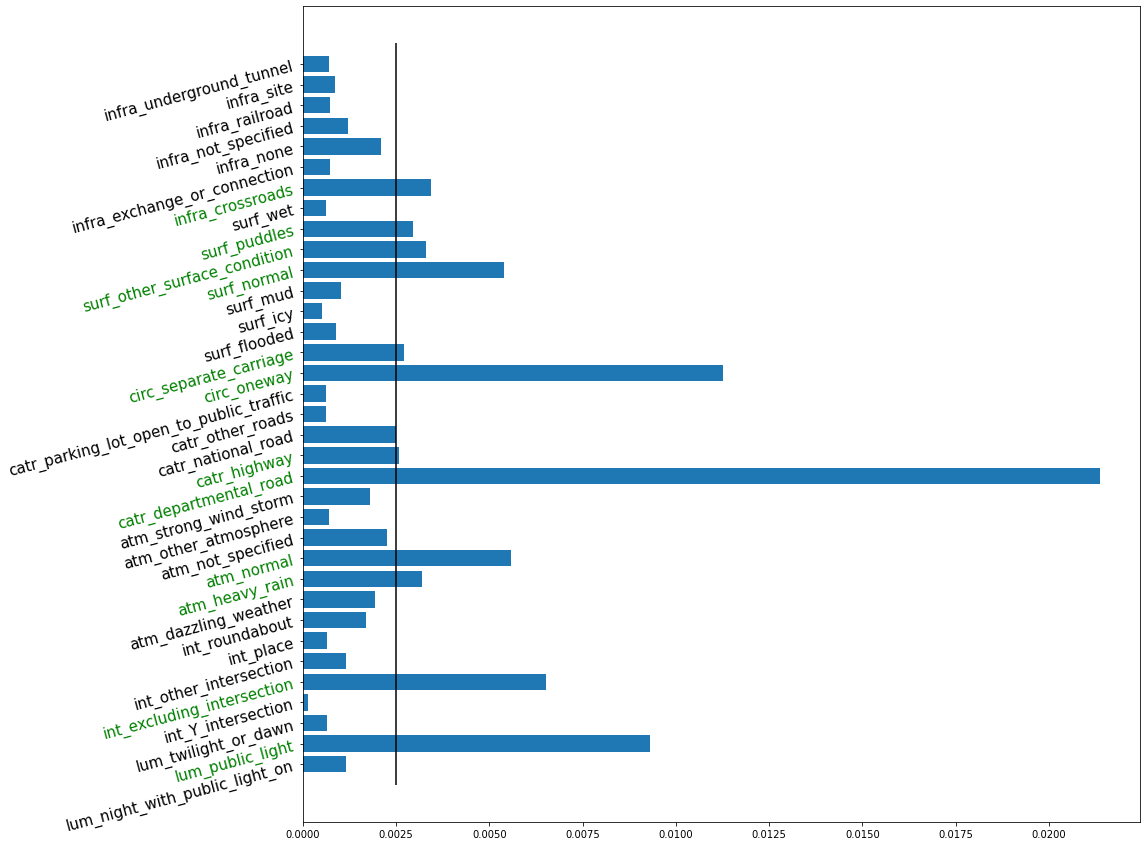

In [ ]:
#hyperparameter threshold. We decided on 0.0025 visually
threshold = 0.0025

fig, axes = plt.subplots( 1,1, figsize=(15,15))

mu = mutual_info_classif(features_df , label_df.values.ravel(), random_state = randomness)


new_mu = []
new_columns = []
new_selected = []
for i in range (0, len(mu)) :
  #filter those with value 0 to shorten graph
  if mu[i] > 0 :
    new_mu.append(mu[i])
    new_columns.append(features_df.columns[i])
  #used later for getting feature columns
  if mu[i] >= threshold: 
    new_selected.append(features_df.columns[i])

pos = np.arange(len(new_mu))
plt.barh(pos , new_mu)
plt.yticks(pos , new_columns)

#draw graph and color in green if its over the threshold (visual purposes only)
for idx , tick in enumerate( axes.yaxis.get_major_ticks()) :
    tick.label.set_fontsize(15)
    tick.label.set_rotation(15)
    if np.squeeze(new_mu)[idx] > threshold :
        tick.label.set_color("green")
        
plt.vlines(x=threshold , ymin =-1 , ymax= len(new_mu))
plt.show()

**Training/test split**

In [ ]:
#training/test size proportion 0~1
TRAINING_SIZE = 0.7 

#set X columns as the green column names in the graph above
X = X[new_selected]

#split training and test for both features and labels
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=TRAINING_SIZE, random_state=randomness, shuffle = True)
print(X_train.shape)
print(X_test.shape)

(115931, 12)
(49685, 12)


**Random Forest**

In [ ]:
#unraveling to avoid warning message
Y_train_forest = Y_train.values.ravel()

#create random forest with 101 trees
clf = RandomForestClassifier(n_estimators = 101, random_state = randomness)

#print out accuracy and f1 score
clf.fit(X_train, Y_train_forest)
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(clf.predict(X_test), Y_test, average='weighted')
print("accuracy: %2.6f" % (accuracy))
print("f1 score: %2.6f" % (f1))
print("\n")

accuracy: 0.357774
f1 score: 0.375476




**Part 2**

**Adding More Data**

In [ ]:
#reload datasets into dataframes
caracteristiques_df = pd.read_csv(data_location+'caracteristiques-2019.csv', encoding_errors = 'ignore')
lieux_df = pd.read_csv(data_location+'lieux-2019.csv')
usagers_df = pd.read_csv(data_location+'usagers-2019.csv')

#selecting data that matches our experiment with the additional data we have mentioned in the report
#new data: secu1, secu2, secu3, an_nais, vma, nbv
caracteristiques_df = caracteristiques_df[['Num_Acc', 'hrmn', 'lum', 'int', 'atm']]
lieux_df = lieux_df[['Num_Acc', 'catr', 'circ', 'surf', 'infra', 'vma', 'nbv']]
usagers_df = usagers_df[['Num_Acc', 'secu1', 'secu2', 'secu3', 'an_nais', 'grav']]

#merge data on same accident number
features_df = pd.merge(caracteristiques_df, lieux_df, on=['Num_Acc']) 

#original data has -1 to be undefined. Hence, we put -1 on NaN as well
features_df.fillna(-1, inplace = True) 

#usagers have repeating accident number but multiple labels hence we want all the unique combinations
features_df = pd.merge (features_df, usagers_df, on="Num_Acc", how="outer").drop_duplicates().reset_index(drop=True) 

#original data has 24 hour between 0 (00:00) to 1 (24:00)
features_df['hrmn'] = features_df['hrmn'].apply(lambda x: x * 24) 

#calculating age by doing 2019 - birthdate. 2019 because this data was collected in 2019
features_df['an_nais'] = features_df['an_nais'].apply(lambda x : 2019 - x)

#check if there are any null values
print(features_df.isnull().values.any()) 
print(features_df.shape)

#replace the numbers with their actual labels (given by the dataset readme)
features_df["lum"] = features_df["lum"].map({-1:"not_specified", 1:"full_day",2:"twilight_or_dawn",3:"public_light",4:"night_with_public_light_not_on",5:"night_with_public_light_on"})
features_df["int"] = features_df["int"].map({-1:"not_specified", 1:"excluding_intersection",2:"X_intersection",3:"T_intersection",4:"Y_intersection",5:"intersecton_with_more_than_4_branches", 6:"roundabout", 7:"place", 8:"level_crossing", 9:"other_intersection"})
features_df["atm"] = features_df["atm"].map({-1:"not_specified", 1:"normal",2:"light_rain",3:"heavy_rain",4:"snow_hail",5:"fog_smoke", 6:"strong_wind_storm", 7:"dazzling_weather", 8:"cloudy_weather", 9:"other_atmosphere"})
features_df["catr"] = features_df["catr"].map({-1:"not_specified", 1:"highway",2:"national_road",3:"departmental_road",4:"communal_road",5:"outside_the_public_network", 6:"parking_lot_open_to_public_traffic", 7:"urban_metropolis_roads",9:"other_roads"}) #they skipped 8 for some reason
features_df["circ"] = features_df["circ"].map({-1:"not_specified",1:"oneway",2:"bidirectional",3:"separate_carriage",4:"variable_assignment", 10:"other_traffic"})
features_df["surf"] = features_df["surf"].map({-1:"not_specified",1:"normal",2:"wet",3:"puddles",4:"flooded", 5:"snowy", 6:"mud", 7:"icy", 8:"fat_oil", 9:"other_surface_condition"})
features_df["infra"] = features_df["infra"].map({-1:"not_specified",0:"none",1:"underground_tunnel",2:"bridge_flyover",3:"exchange_or_connection",4:"railroad", 5:"crossroads", 6:"pedestrian_zone", 7:"toll_zone", 8:"site", 9:"other_infrastructure"})
features_df['grav'] = features_df['grav'].map({1:"noharm", 2:"dead", 3:"slight", 4:"very"})
features_df["secu1"] = features_df["secu1"].map({-1:"not_specified",0:"none",1: "belt" ,2:"helmet",3:"children_device",4:"reflective_vest", 5:"airbag", 6:"gloves", 7:"airbag_and_gloves", 8:"undefined", 9:"other"})
features_df["secu2"] = features_df["secu2"].map({-1:"not_specified",0:"none",1: "belt" ,2:"helmet",3:"children_device",4:"reflective_vest", 5:"airbag", 6:"gloves", 7:"airbag_and_gloves", 8:"undefined", 9:"other"})
features_df["secu3"] = features_df["secu3"].map({-1:"not_specified",0:"none",1: "belt" ,2:"helmet",3:"children_device",4:"reflective_vest", 5:"airbag", 6:"gloves", 7:"airbag_and_gloves", 8:"undefined", 9:"other"})

#checking
features_df.head()

False
(130713, 16)


,Num_Acc,hrmn,lum,int,atm,catr,circ,surf,infra,vma,nbv,secu1,secu2,secu3,an_nais,grav
0,201900000001,1.500000,night_with_public_light_not_on,excluding_intersection,normal,highway,separate_carriage,normal,bridge_flyover,70.0,10.0,belt,none,not_specified,17,very
1,201900000001,1.500000,night_with_public_light_not_on,excluding_intersection,normal,highway,separate_carriage,normal,bridge_flyover,70.0,10.0,belt,none,not_specified,26,very
2,201900000001,1.500000,night_with_public_light_not_on,excluding_intersection,normal,highway,separate_carriage,normal,bridge_flyover,70.0,10.0,belt,none,not_specified,60,noharm
3,201900000002,2.833333,public_light,excluding_intersection,normal,highway,oneway,normal,none,70.0,2.0,belt,none,not_specified,25,very
4,201900000003,15.250000,full_day,excluding_intersection,normal,highway,separate_carriage,normal,none,90.0,8.0,belt,none,not_specified,23,noharm


**Separating features and label**

In [ ]:
 #get label data separate
label_df = features_df[['grav']]

#get rid of Num_Acc since it is no longer needed and does nothing and drop label from features
features_df = features_df.drop(columns = ['grav', 'Num_Acc']) 

**One hot Encoding**

In [ ]:
features_df = pd.get_dummies(features_df, drop_first = True)

**Upsampling**

In [ ]:
#we are upsampling everything that is not the majority
oversample = SMOTE(sampling_strategy = "not majority", random_state = randomness)
X,Y = oversample.fit_resample(features_df, label_df)

**Feature Selection**

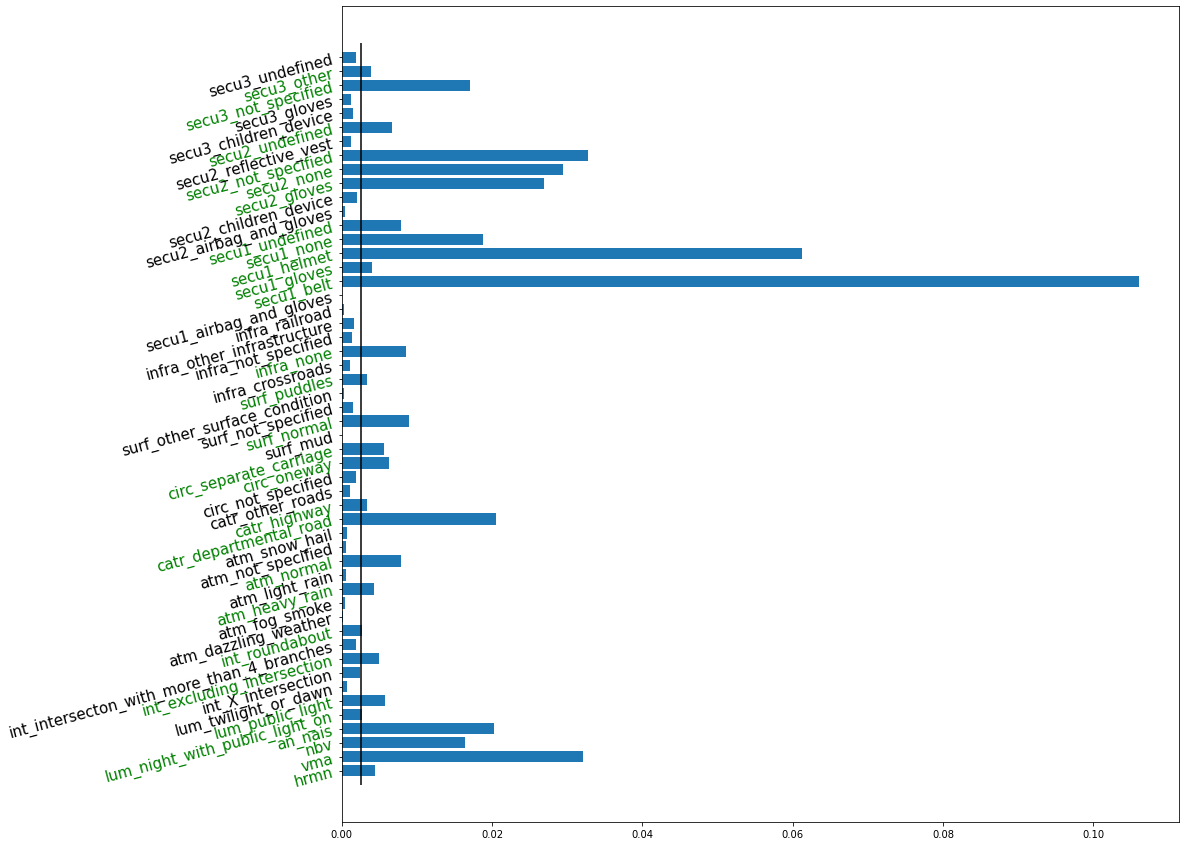

In [ ]:
#hyperparameter threshold. We decided on 0.0025 visually
threshold = 0.0025

fig, axes = plt.subplots( 1,1, figsize=(15,15))

mu = mutual_info_classif(features_df , label_df.values.ravel(), random_state = randomness)


new_mu = []
new_columns = []
new_selected = []
for i in range (0, len(mu)) :
  #filter those with value 0 to shorten graph
  if mu[i] > 0 :
    new_mu.append(mu[i])
    new_columns.append(features_df.columns[i])
  #used later for getting feature columns
  if mu[i] >= threshold: 
    new_selected.append(features_df.columns[i])

pos = np.arange(len(new_mu))
plt.barh(pos , new_mu)
plt.yticks(pos , new_columns)

#draw graph and color in green if its over the threshold (visual purposes only)
for idx , tick in enumerate( axes.yaxis.get_major_ticks()) :
    tick.label.set_fontsize(15)
    tick.label.set_rotation(15)
    if np.squeeze(new_mu)[idx] > threshold :
        tick.label.set_color("green")
        
plt.vlines(x=threshold , ymin =-1 , ymax= len(new_mu))
plt.show()

**Training/test split**

In [ ]:
#training/test size proportion 0~1
TRAINING_SIZE = 0.7 

#set X columns as the green column names in the graph above
X = X[new_selected]

#split training and test for both features and labels
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=TRAINING_SIZE, random_state=randomness, shuffle = True)
print(X_train.shape)
print(X_test.shape)

(151978, 28)
(65134, 28)


**Random Forest**

In [ ]:
#unraveling to avoid warning message
Y_train_forest = Y_train.values.ravel()

#create random forest with 101 trees
clf = RandomForestClassifier(n_estimators = 101, random_state = randomness)

#print out accuracy and f1 score
clf.fit(X_train, Y_train_forest)
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(clf.predict(X_test), Y_test, average='weighted')
print("accuracy: %2.6f" % (accuracy))
print("f1 score: %2.6f" % (f1))
print("\n")

accuracy: 0.689809
f1 score: 0.692542




**Other Learning Models**

**Stratified K Fold Cross Validation WITH Upsampling**

In [ ]:
#choose model as a decision tree and train it
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

#stratified K-fold 
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = randomness)


print((cross_val_score(decision_tree, X_test, Y_test, cv = cv, scoring='accuracy')).mean())

0.5746615654967677


**Stratified K Fold Cross Validation WITHOUT Upsampling**

**Refetching X and Y**

In [ ]:
#reusing features and labels
X_other = features_df
Y_other = label_df

#reusing feature selection
X_other = X_other[new_selected]

**Training/test Split**

In [ ]:
#training/test size proportion 0~1
TRAINING_SIZE = 0.7 

#split training and test for both features and labels
X_train, X_test, Y_train, Y_test = train_test_split(X_other,Y_other, train_size=TRAINING_SIZE, random_state=randomness, shuffle = True)
print(X_train.shape)
print(X_test.shape)

(91499, 28)
(39214, 28)


**Cross Validation (No Upsampling)**

In [ ]:
#choose model as a decision tree and train it
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

#stratified K-fold 
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = randomness)


print((cross_val_score(decision_tree, X_test, Y_test, cv = cv, scoring='accuracy')).mean())

0.47490689101596384


**Logistic Regression**
Does not use upsampling

**Multi-Output Logistic Regression With Only Numeric**

In [ ]:
MAX_ITER = X_train.shape[0] + 1

#get only the numeric values
X_numeric_train = X_train[['an_nais', 'hrmn', 'vma', 'nbv']]
X_numeric_test = X_test[['an_nais', 'hrmn', 'vma', 'nbv']]

#Logistic Regression
clf = MultiOutputClassifier(LogisticRegression(max_iter=MAX_ITER)).fit(X_numeric_train, Y_train)
print("accuracy: %2.6f" % (clf.score(X_numeric_test, Y_test)))
print("f1 score: %2.6f" % (f1_score(clf.predict(X_numeric_test), Y_test, average='weighted')))

accuracy: 0.451981
f1 score: 0.497085


**Multi-Output Logistic Regression**

In [ ]:
MAX_ITER = X_train.shape[0] + 1

#Logistic Regression
clf = MultiOutputClassifier(LogisticRegression(max_iter=MAX_ITER)).fit(X_train, Y_train)
print("accuracy: %2.6f" % (clf.score(X_test, Y_test)))
print("f1 score: %2.6f" % (f1_score(clf.predict(X_test), Y_test, average='weighted')))

accuracy: 0.582981
f1 score: 0.608852
